# Histopathologic Cancer Detection

In [88]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
import pandas
import os
import cv2
import numpy as np
import random
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

In [15]:
TRAIN_PATH = "./dataset/train/"
TEST_PATH = "./dataset/test/"
IMG_WIDTH, IMG_HEIGHT = 16, 16
# Between 1 and 220025
NUMBER_OF_SAMPLES = 200000
FILE_NAME = str(int(NUMBER_OF_SAMPLES / 1000)) + f'K-{IMG_WIDTH}x{IMG_HEIGHT}.npy'
LOAD_MATRICES = True

In [16]:
df = pandas.read_csv("./dataset/train_labels.csv")
df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


### Check if null
We should make sure that there are no `null` fields in the dataset.
If there were any:
* Remove data row
* Fill according to other data (Which can not be done here, as the data are images)

In [17]:
number_of_empty_id_rows = len(df[df.id.isnull()])
number_of_empty_label_rows = len(df[df.label.isnull()])

if number_of_empty_id_rows == 0:
    print("[NOTE]: Dataset 'id' column has no 'Null' values. No need to fill/remove rows.")
if number_of_empty_label_rows == 0:
    print("[NOTE]: Dataset 'label' column has no 'Null' values. No need to fill/remove rows.")

[NOTE]: Dataset 'id' column has no 'Null' values. No need to fill/remove rows.
[NOTE]: Dataset 'label' column has no 'Null' values. No need to fill/remove rows.


### Understanding dataset

* Sampling positive and negative samples will help us understand the dataset.

In [18]:
positive_tumor_samples = df[df.label == 1]
number_of_posive_tumor_samples = len(positive_tumor_samples)
number_of_posive_tumor_samples
print(f"Number of positive tumor samples: {number_of_posive_tumor_samples}")

Number of positive tumor samples: 89117


In [19]:
negative_tumor_samples = df[df.label == 0]
number_of_negative_tumor_samples = len(negative_tumor_samples)
number_of_negative_tumor_samples
print(f"Number of negative tumor samples: {number_of_negative_tumor_samples}")

Number of negative tumor samples: 130908


## Data Information provided by [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The `train_labels.csv` file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. ***A positive label indicates that the center `32x32px` region of a patch contains at least one pixel of tumor tissue.*** Tumor tissue in the outer region of the patch ***does not*** influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

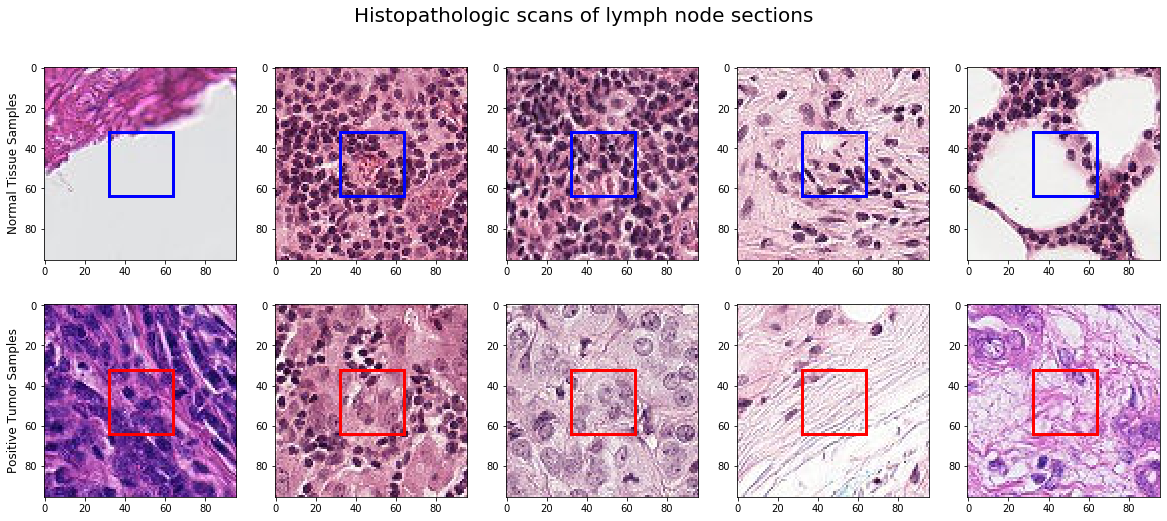

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

ax[0, 0].set_ylabel("Normal Tissue Samples", size='large')
ax[1, 0].set_ylabel("Positive Tumor Samples", size='large')

for i in range(5):
    # Negative Tumor Tissue Sample
    random_negative_sample = negative_tumor_samples.iloc[random.randint(0, number_of_negative_tumor_samples)]
    random_negative_sample_id = random_negative_sample.id
    random_negative_sample_label = random_negative_sample.label
    random_negative_sample_path = os.path.join(TRAIN_PATH, random_negative_sample_id) + '.tif'
    random_negative_img = cv2.imread(random_negative_sample_path)
    random_negative_img = cv2.cvtColor(random_negative_img, cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='b', facecolor='none')
    ax[0, i].add_patch(rect)
    ax[0, i].imshow(random_negative_img)
    
    # Positive Tumor Tissue Samples
    random_positive_sample = positive_tumor_samples.iloc[random.randint(0, number_of_posive_tumor_samples)]
    random_positive_sample_id = random_positive_sample.id
    random_positive_sample_label = random_positive_sample.label
    random_positive_sample_path = os.path.join(TRAIN_PATH, random_positive_sample_id) + '.tif'
    random_positive_img = cv2.imread(random_positive_sample_path)
    random_positive_img = cv2.cvtColor(random_positive_img, cv2.COLOR_BGR2RGB)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=3, edgecolor='r', facecolor='none')
    ax[1, i].imshow(random_positive_img)
    ax[1, i].add_patch(rect)

In [21]:
def read_convert_images_from_df(dataframe, base_dir):
    img_list = []
    img_label_list = []
    total_number_of_data = NUMBER_OF_SAMPLES
    for index, img_datum in dataframe.iterrows():
        if index < NUMBER_OF_SAMPLES:
            print(f"{index + 1} out of {total_number_of_data}")
            print(f"Image ID: {img_datum.id}, Label: {img_datum.label}")
            img_id = img_datum.id
            img_label = df[df.id == img_id].iloc[0].label
            img_path = os.path.join(base_dir, img_id) + '.tif'
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = np.asarray(img, dtype=float)
            img /= 255.0
            img_list.append(img)
            img_label_list.append(img_label)
    return img_list, img_label_list

In [22]:
def read_convert_images_from_path(path):
    img_list = []
    img_id_list = []
    for idx, img_name in enumerate(os.listdir(path)):
        print(f"{idx + 1} out of {NUMBER_OF_SAMPLES}")
        img_id = img_name.split(".tif")[0]
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = np.asarray(img, dtype=float)
        img /= 255.0
        img_list.append(img)
        img_id_list.append(img_id)
    img_list = np.asarray(img_list, dtype='float')
    img_id_list = np.asarray(img_id_list)
    return img_list, img_id_list

In [23]:
def load_matrices():
    X = np.load(f'./matrices/X_{FILE_NAME}')
    y = np.load(f'./matrices/y_{FILE_NAME}')
    
    X_eval = np.load('./matrices/X_EVAL.npy')
    ID_eval = np.load('./matrices/ID_EVAL.npy')
    
    return X, y, X_eval, ID_eval

In [107]:
if LOAD_MATRICES:
    X, y, X_eval, ID_eval = load_matrices()
    print(f"X Shape: {X.shape}")
    print(f"y Shape: {y.shape}")
    print(f"X eval Shape: {X_eval.shape}")
    print(f"ID eval Shape: {ID_eval.shape}")
else:
    X, y = read_convert_images_from_df(df, TRAIN_PATH)
    
    X_eval, ID_eval = read_convert_images_from_path(TEST_PATH)
    
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)
    
    np.save(f'./matrices/X_{FILE_NAME}', X)
    np.save(f'./matrices/y_{FILE_NAME}', y)
    
    np.save('./matrices/X_EVAL.npy', X_eval)
    np.save('./matrices/ID_EVAL.npy', ID_eval)
    
    print("X saved!")
    print("y saved!")
    
    print("X eval saved!")
    print("ID eval saved!")
    
    print(f"X Shape: {X.shape}")
    print(f"y Shape: {y.shape}")
    
    print(f"X eval Shape: {X_eval.shape}")
    print(f"ID eval Shape: {ID_eval.shape}")

X Shape: (200000, 16, 16, 3)
y Shape: (200000,)
X eval Shape: (57458, 16, 16, 3)
ID eval Shape: (57458,)


In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [109]:
print(f"X Train shape: {x_train.shape}\ny train Shape: {x_train.shape}\nX Test shape: {x_test.shape}\ny test shape: {y_test.shape}")

X Train shape: (160000, 16, 16, 3)
y train Shape: (160000, 16, 16, 3)
X Test shape: (40000, 16, 16, 3)
y test shape: (40000,)


In [110]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='input_layer'),
    layers.Dense(16, activation='relu', kernel_regularizer=L2(0.001)),
    layers.Dense(64, activation='relu'),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001)),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(256, activation='relu'),
    layers.MaxPool2D((3, 3), padding='same'),
    layers.Dense(128, activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
], name='Simple_CNN_16x16_200K_Tuned')

In [111]:
model.summary()

Model: "Simple_CNN_16x16_200K_Tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16, 16, 16)        64        
_________________________________________________________________
dense_43 (Dense)             (None, 16, 16, 64)        1088      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dense_44 (Dense)             (None, 6, 6, 512)         33280     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 512)         0         
_________________________________________________________________
dense_45 (Dense)             (None, 2, 2, 256)         131328    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 

In [112]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [114]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50, callbacks=[tensorboard_callback])

Epoch 1/50
625/625 [==============================] - 6s 9ms/step - loss: 0.5664 - accuracy: 0.7239 - val_loss: 0.4791 - val_accuracy: 0.7871
Epoch 2/50
625/625 [==============================] - 5s 8ms/step - loss: 0.4590 - accuracy: 0.7975 - val_loss: 0.4247 - val_accuracy: 0.8176
Epoch 3/50
625/625 [==============================] - 5s 9ms/step - loss: 0.4176 - accuracy: 0.8231 - val_loss: 0.3908 - val_accuracy: 0.8393
Epoch 4/50
625/625 [==============================] - 5s 9ms/step - loss: 0.4018 - accuracy: 0.8303 - val_loss: 0.3915 - val_accuracy: 0.8375
Epoch 5/50
625/625 [==============================] - 5s 9ms/step - loss: 0.3888 - accuracy: 0.8364 - val_loss: 0.3693 - val_accuracy: 0.8490
Epoch 6/50
625/625 [==============================] - 5s 9ms/step - loss: 0.3759 - accuracy: 0.8433 - val_loss: 0.3728 - val_accuracy: 0.8419
Epoch 7/50
625/625 [==============================] - 5s 9ms/step - loss: 0.3709 - accuracy: 0.8452 - val_loss: 0.3539 - val_accuracy: 0.8541
Epoch 

In [115]:
def predict(x_test):
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    return y_pred

In [116]:
y_pred_eval = predict(X_eval)

In [117]:
if os.path.exists('./submission.csv'):
    !rm submission.csv
    print("Removed old version.")

with open('./submission.csv', 'w+') as f:
    f.write("id,label\n")
    for idx, y in enumerate(y_pred_eval):
        f.write(f'{ID_eval[idx]},{y[0]}\n')
    print("Submission.csv file created!")

Removed old version.
Submission.csv file created!


In [118]:
!./submit_csv.sh SimpleCNN-16x16-200K_Tuned

100%|███████████████████████████████████████| 2.36M/2.36M [00:07<00:00, 348kB/s]
Successfully submitted to Histopathologic Cancer Detection
Follow link https://www.kaggle.com/c/histopathologic-cancer-detection/submissions to view results.


In [119]:
def plot_loss_acc(history, model_name): 
    os.mkdir(f'./plots/{model_name}')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'./plots/{model_name}/acc.png')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'./plots/{model_name}/loss.png')
    plt.show()

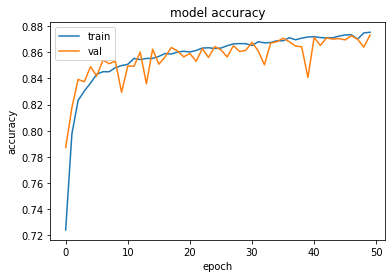

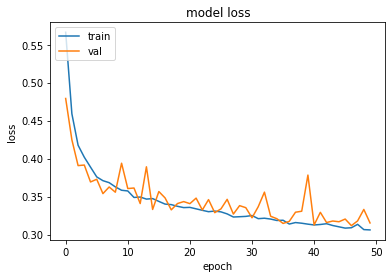

In [120]:
plot_loss_acc(history, model.name)